In [1]:
import numpy as np
import pymaster as nmt
import matplotlib.pyplot as plt

In [2]:
# This script describes the functionality of the flat-sky version of pymaster

# Dimensions:
# First, a flat-sky field is defined by four quantities:
#  - Lx and Ly: the size of the patch in the x and y dimensions (in radians)
Lx = 20. * np.pi/180
Ly = 20. * np.pi/180
#  - Nx and Ny: the number of pixels in the x and y dimensions
Nx = 800
Ny = 800

In [3]:
import pickle
from scipy.interpolate import interp1d
oup_fname = '../data/input/universe_Planck15/camb/CAMB_outputs.pkl'
f = open(oup_fname, 'rb') 
powers,cl,c_lensed,c_lens_response = pickle.load(f)
f.close()

totCL=powers['total']
unlensedCL=powers['unlensed_scalar']

#unlensed
L = np.arange(unlensedCL.shape[0])

unlensedTT = unlensedCL[:,0]
F = unlensedTT
funlensedTT = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

unlensedEE = unlensedCL[:,1]
F = unlensedEE
funlensedEE = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

unlensedBB = unlensedCL[:,2]
F = unlensedBB
funlensedBB = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

unlensedTE = unlensedCL[:,3]
F = unlensedTE
funlensedTE = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

In [4]:
# Gaussian simulations:
# pymaster allows you to generate random realizations of both spherical and
# flat fields given a power spectrum. These are returned as 2D arrays with
# shape (Ny,Nx)
beam = np.exp(-(0.25 * np.pi/180 * L)**2)
cl_tt = unlensedTT*beam
cl_ee = unlensedEE*beam
cl_bb = unlensedBB*beam
cl_te = unlensedTE*beam
mpt, mpq, mpu = nmt.synfast_flat(Nx, Ny, Lx, Ly,
                                 np.array([cl_tt, cl_te, 0 * cl_tt,
                                           cl_ee, 0 * cl_ee, cl_bb]),
                                 [0, 2])

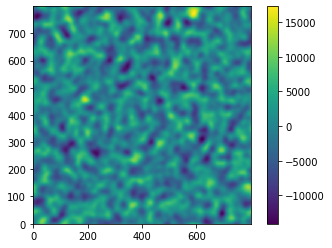

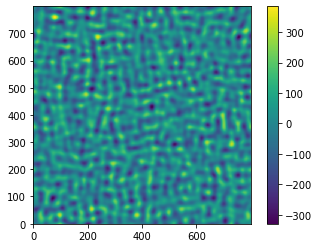

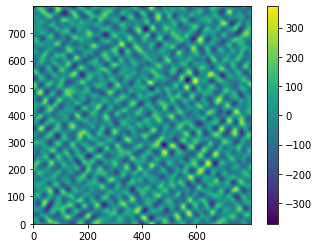

In [5]:
# You can have a look at the maps using matplotlib's imshow:
plt.figure()
plt.imshow(mpt, interpolation='nearest', origin='lower')
plt.colorbar()
plt.figure()
plt.imshow(mpq, interpolation='nearest', origin='lower')
plt.colorbar()
plt.figure()
plt.imshow(mpu, interpolation='nearest', origin='lower')
plt.colorbar()
plt.show()

In [6]:
# Masks:
# Let's now create a mask:
mask = np.ones_like(mpt).flatten()
xarr = np.ones(Ny)[:, None] * np.arange(Nx)[None, :] * Lx/Nx
yarr = np.ones(Nx)[None, :] * np.arange(Ny)[:, None] * Ly/Ny

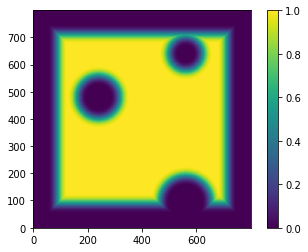

In [7]:
# First we dig a couple of holes
def dig_hole(x, y, r):
    rad = (np.sqrt((xarr - x)**2 + (yarr - y)**2)).flatten()
    return np.where(rad < r)[0]


mask[dig_hole(0.3 * Lx, 0.6 * Ly, 0.05 * np.sqrt(Lx * Ly))] = 0.
mask[dig_hole(0.7 * Lx, 0.12 * Ly, 0.07 * np.sqrt(Lx * Ly))] = 0.
mask[dig_hole(0.7 * Lx, 0.8 * Ly, 0.03 * np.sqrt(Lx * Ly))] = 0.
# Let's also trim the edges
mask[np.where(xarr.flatten() < Lx / 16.)] = 0
mask[np.where(xarr.flatten() > 15 * Lx / 16.)] = 0
mask[np.where(yarr.flatten() < Ly / 16.)] = 0
mask[np.where(yarr.flatten() > 15 * Ly / 16.)] = 0
mask = mask.reshape([Ny, Nx])
# You can also apodize it in the same way you do for full-sky masks:
mask = nmt.mask_apodization_flat(mask, Lx, Ly, aposize=2., apotype="C1")
plt.figure()
plt.imshow(mask, interpolation='nearest', origin='lower')
plt.colorbar()
plt.show()

In [8]:
# Fields:
# Once you have maps it's time to create pymaster fields.
# Note that, as in the full-sky case, you can also pass
# contaminant templates and flags for E and B purification
# (see the documentation for more details)
f0 = nmt.NmtFieldFlat(Lx, Ly, mask, [mpt])
f2 = nmt.NmtFieldFlat(Lx, Ly, mask, [mpq, mpu], purify_b=True)

In [9]:
# Bins:
# For flat-sky fields, bandpowers are simply defined as intervals in ell, and
# pymaster doesn't currently support any weighting scheme within each interval.
l0_bins = np.arange(Nx/8) * 8 * np.pi/Lx
lf_bins = (np.arange(Nx/8)+1) * 8 * np.pi/Lx
b = nmt.NmtBinFlat(l0_bins, lf_bins)
# The effective sampling rate for these bandpowers can be obtained calling:
ells_uncoupled = b.get_effective_ells()

In [10]:
# Workspaces:
# As in the full-sky case, the computation of the coupling matrix and of
# the pseudo-CL estimator is mediated by a WorkspaceFlat case, initialized
# by calling its compute_coupling_matrix method:
w00 = nmt.NmtWorkspaceFlat()
w00.compute_coupling_matrix(f0, f0, b)
# Workspaces can be saved to and read from disk to avoid recomputing them:
# w00.write_to("w00_flat.fits")
# w00.read_from("w00_flat.fits")


In [11]:
# Computing power spectra:
# As in the full-sky case, you compute the pseudo-CL estimator by
# computing the coupled power spectra and then decoupling them by
# inverting the mode-coupling matrix. This is done in two steps below,
# but pymaster provides convenience routines to do this
# through a single function call
cl00_coupled = nmt.compute_coupled_cell_flat(f0, f0, b)
cl00_uncoupled = w00.decouple_cell(cl00_coupled)

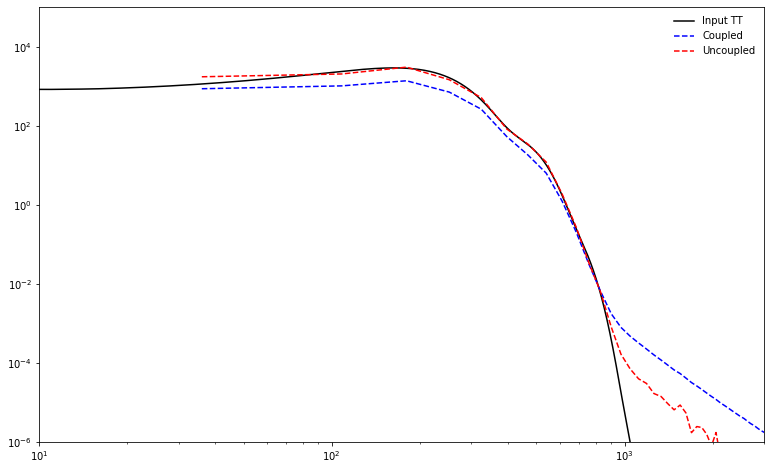

In [26]:
plt.rcParams['text.usetex'] = True

plt.rcParams['font.size'] = 20


plt.figure(figsize=(13,8))

plt.plot(L, cl_tt, 'k', label='Input TT')
# plt.plot(ells_uncoupled, cl00_coupled[0], 'b--', label='Coupled')

plt.plot(ells_uncoupled, cl00_uncoupled[0], 'r--', label='Uncoupled')

plt.loglog()
plt.ylim(1e-6,1e5)
plt.xlim(10, 3e3)
plt.legend(frameon=False)
plt.show()